<a href="https://colab.research.google.com/github/shivanesh31/Shivanesh/blob/main/my_labs/BigData_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Introduction**

Exploratory Data Analysis on NYC Taxi data

Import Data from Kaggle using Kaggle API

In [3]:
! pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d elemento/nyc-yellow-taxi-trip-data

mkdir: cannot create directory ‘/root/.kaggle’: File exists
nyc-yellow-taxi-trip-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip nyc-yellow-taxi-trip-data.zip

Archive:  nyc-yellow-taxi-trip-data.zip
replace yellow_tripdata_2015-01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace yellow_tripdata_2016-01.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace yellow_tripdata_2016-02.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace yellow_tripdata_2016-03.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# **Libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()


Import the Data

In [7]:
df = pd.read_csv("/content/yellow_tripdata_2015-01.csv")


Explore the Data


In [7]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [ ]:
# This library helps to open street map
import folium

# Similar to pandas, but helps in parallel computing
# Below are some resources for getting familiar with Dask
# https://www.youtube.com/watch?v=ieW3G7ZzRZ0
# https://github.com/dask/dask-tutorial
# https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
import dask.dataframe as dd

# This library is used while we calculate the straight line distance between two (lat, lon) pairs
# in miles. Get the haversine distance
import gpxpy.geo

# Used to determine the size of plots
from matplotlib import rcParams

# https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.doa.detect_peaks.html
# Used for detection of peaks
from pyroomacoustics.doa.detect_peaks import detect_peaks

# Download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# Install it in your system and keep the path, migw_path ='installed path'
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

from prettytable import PrettyTable
from datetime import datetime as dt

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline

# To find the running time of the entire kernel
globalstart = dt.now()

In [6]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [8]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

# **General Statistics**




In [9]:
df.size

242230734

In [10]:
df.shape

(12748986, 19)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748986 entries, 0 to 12748985
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.8+ GB


In [12]:
df_overview = DfOverview(df)
df_overview.getOverview().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Column,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748986,12748983,12748986
missing_value_count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
Missing_value_percentage,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
unique_value_count,2,2438284,2442163,10,4350,35900,62748,7,2,53297,87523,5,2053,55,3,3596,932,2,11969
unique_value_percentage,0.0%,19.13%,19.16%,0.0%,0.03%,0.28%,0.49%,0.0%,0.0%,0.42%,0.69%,0.0%,0.02%,0.0%,0.0%,0.03%,0.01%,0.0%,0.09%
dtype,int64,object,object,int64,float64,float64,float64,int64,object,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64


In [13]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [14]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

In [15]:
drop_duplicates(df)

383 duplicate rows were found and removed.


In [ ]:
print(df['VendorID'].nunique())
print(df['tpep_pickup_datetime'].nunique())
print(df['tpep_dropoff_datetime'].nunique())
print(df['passenger_count'].nunique())
print(df['trip_distance'].nunique())
print(df['pickup_longitude'].nunique())
print(df['pickup_latitude'].nunique())
print(df['RateCodeID'].nunique())
print(df['store_and_fwd_flag'].nunique())
print(df['dropoff_longitude'].nunique())
print(df['dropoff_latitude'].nunique())
print(df['payment_type'].nunique())
print(df['fare_amount'].nunique())
print(df['extra'].nunique())
print(df['mta_tax'].nunique())
print(df['tip_amount'].nunique())
print(df['tolls_amount'].nunique())
print(df['improvement_surcharge'].nunique())
print(df['total_amount'].nunique())

2
2438284
2442163
10
4350
35900
62748
7
2
53297
87523
5
2053
55
3
3596
932
2
11969


# **Univariate Analysis**

1. VendorID

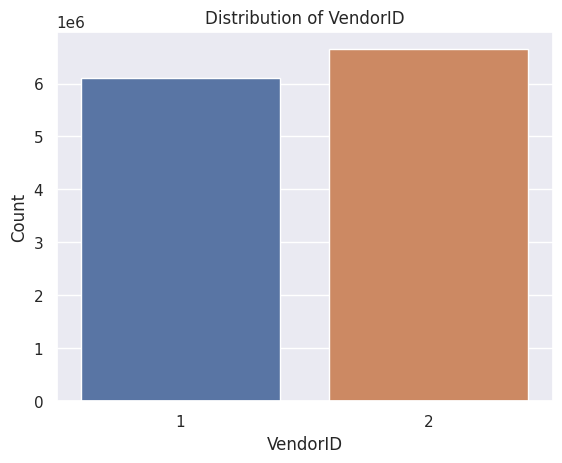

In [16]:
# Create a count plot
sns.countplot(x='VendorID', data=df)

# Set labels and title
plt.xlabel('VendorID')
plt.ylabel('Count')
plt.title('Distribution of VendorID')

# Show the plot
plt.show()



We've observed that there are only two vendors (Vendor 1 and Vendor 2). Both vendors have nearly equal trip shares, with a minimal difference between them. However, Vendor 2 is noticeably more renowned among the population, as indicated by the graphs provided.

2. Passengers

In [29]:
pd.options.display.float_format = '{:.2f}'.format #To suppress scientific notation.
df.passenger_count.value_counts()

1    8993507
2    1814574
5     697645
3     528486
6     454568
4     253228
0       6565
9         11
8         10
7          9
Name: passenger_count, dtype: int64

<ipython-input-28-a5d4debf96bd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['passenger_count'],kde=False)


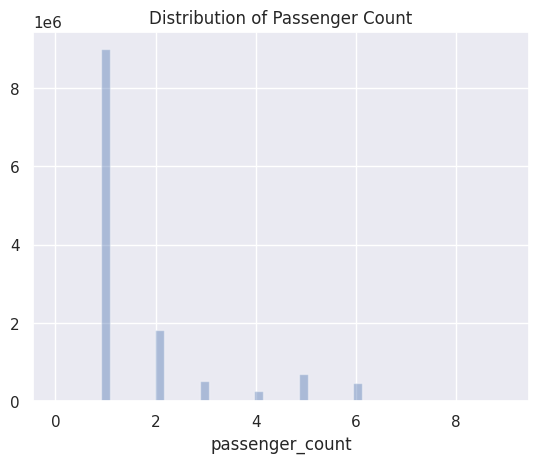

In [28]:
sns.distplot(df['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

2. Duration of the travel

In [7]:
# Convert the tpep_pickup_datetime and tpep_dropoff_datetime columns to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate the time difference and create a new column
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

# Extract the duration in seconds, if needed
df['duration_seconds'] = df['duration'].dt.total_seconds()

# Display the DataFrame with the calculated duration
print(df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'duration']])


         tpep_pickup_datetime tpep_dropoff_datetime        duration
0         2015-01-15 19:05:39   2015-01-15 19:23:42 0 days 00:18:03
1         2015-01-10 20:33:38   2015-01-10 20:53:28 0 days 00:19:50
2         2015-01-10 20:33:38   2015-01-10 20:43:41 0 days 00:10:03
3         2015-01-10 20:33:39   2015-01-10 20:35:31 0 days 00:01:52
4         2015-01-10 20:33:39   2015-01-10 20:52:58 0 days 00:19:19
...                       ...                   ...             ...
12748981  2015-01-10 19:01:44   2015-01-10 19:05:40 0 days 00:03:56
12748982  2015-01-10 19:01:44   2015-01-10 19:07:26 0 days 00:05:42
12748983  2015-01-10 19:01:44   2015-01-10 19:15:01 0 days 00:13:17
12748984  2015-01-10 19:01:44   2015-01-10 19:17:03 0 days 00:15:19
12748985  2015-01-10 19:01:45   2015-01-10 19:07:33 0 days 00:05:48

[12748986 rows x 3 columns]


<ipython-input-13-b5b5cc64f669>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration'],kde=False)


Text(0.5, 1.0, 'The distribution of of the Pick Up  Duration distribution')

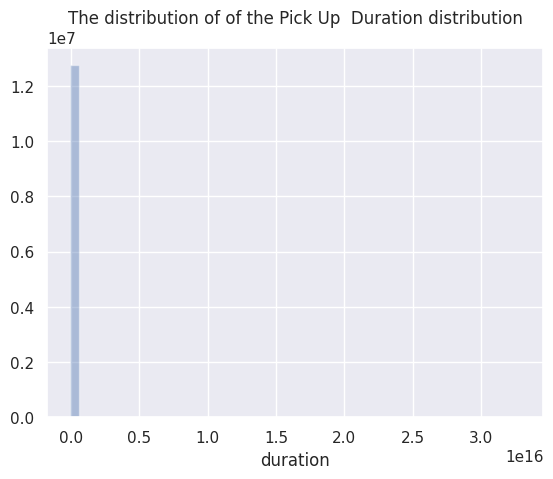

In [13]:
sns.distplot(df['duration'],kde=False)
plt.title('The distribution of of the Pick Up  Duration distribution')

In [17]:
df.dtypes

VendorID                           int64
tpep_pickup_datetime      datetime64[ns]
tpep_dropoff_datetime     datetime64[ns]
passenger_count                    int64
trip_distance                    float64
pickup_longitude                 float64
pickup_latitude                  float64
RateCodeID                         int64
store_and_fwd_flag                object
dropoff_longitude                float64
dropoff_latitude                 float64
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
duration                 timedelta64[ns]
duration_seconds                 float64
pickup_day                        object
dropoff_day                       object
dtype: object

Text(0.5, 1.0, 'A boxplot depicting the pickup duration distribution')

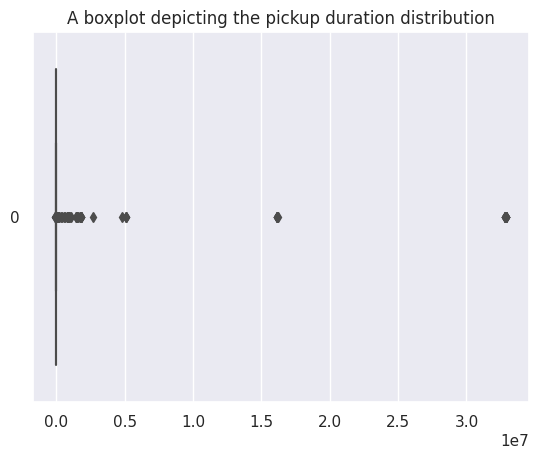

In [18]:
sns.boxplot(df['duration_seconds'], orient='horizontal')
plt.title('A boxplot depicting the pickup duration distribution')

In [20]:

print( df['duration_seconds'].nlargest(10))


2526363     32913338.0
2526362     32911853.0
2479740     32909576.0
2479739     32909274.0
2479738     32909001.0
2479737     32908258.0
2479736     32906498.0
2479735     32905773.0
2479734     32904619.0
12395109    32836502.0
Name: duration_seconds, dtype: float64


In [23]:
df.duration_seconds.groupby(pd.cut(df.duration_seconds, np.arange(1,max(df.duration_seconds),3600))).count()

duration_seconds
(1.0, 3601.0]               12684512
(3601.0, 7201.0]               36666
(7201.0, 10801.0]               1047
(10801.0, 14401.0]               350
(14401.0, 18001.0]               151
                              ...   
(32893201.0, 32896801.0]           0
(32896801.0, 32900401.0]           0
(32900401.0, 32904001.0]           0
(32904001.0, 32907601.0]           3
(32907601.0, 32911201.0]           4
Name: duration_seconds, Length: 9142, dtype: int64

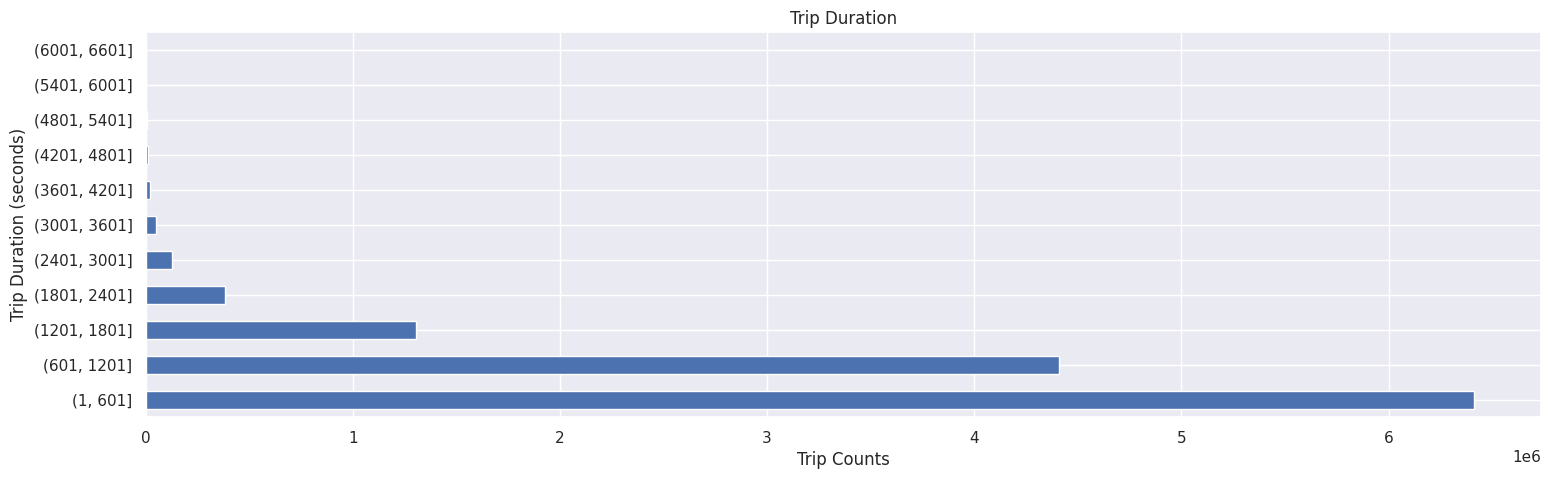

In [24]:
df.duration_seconds.groupby(pd.cut(df.duration_seconds, np.arange(1,7200,600))).count().plot(kind='barh',figsize = (18,5))
plt.title('Trip Duration')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

3. The distribution of Pickup and Drop Off day of the week

In [8]:
df['pickup_day']=df['tpep_pickup_datetime'].dt.day_name()
df['dropoff_day']=df['tpep_dropoff_datetime'].dt.day_name()

In [21]:
df['pickup_day'].value_counts()

Saturday     2379707
Friday       2227157
Thursday     2168213
Wednesday    1683789
Sunday       1583098
Tuesday      1373922
Monday       1332717
Name: pickup_day, dtype: int64

In [22]:
df['dropoff_day'].value_counts()

Saturday     2378985
Friday       2216789
Thursday     2160689
Wednesday    1681098
Sunday       1604381
Tuesday      1371308
Monday       1335353
Name: dropoff_day, dtype: int64

***Most trips were taken on Saturday***

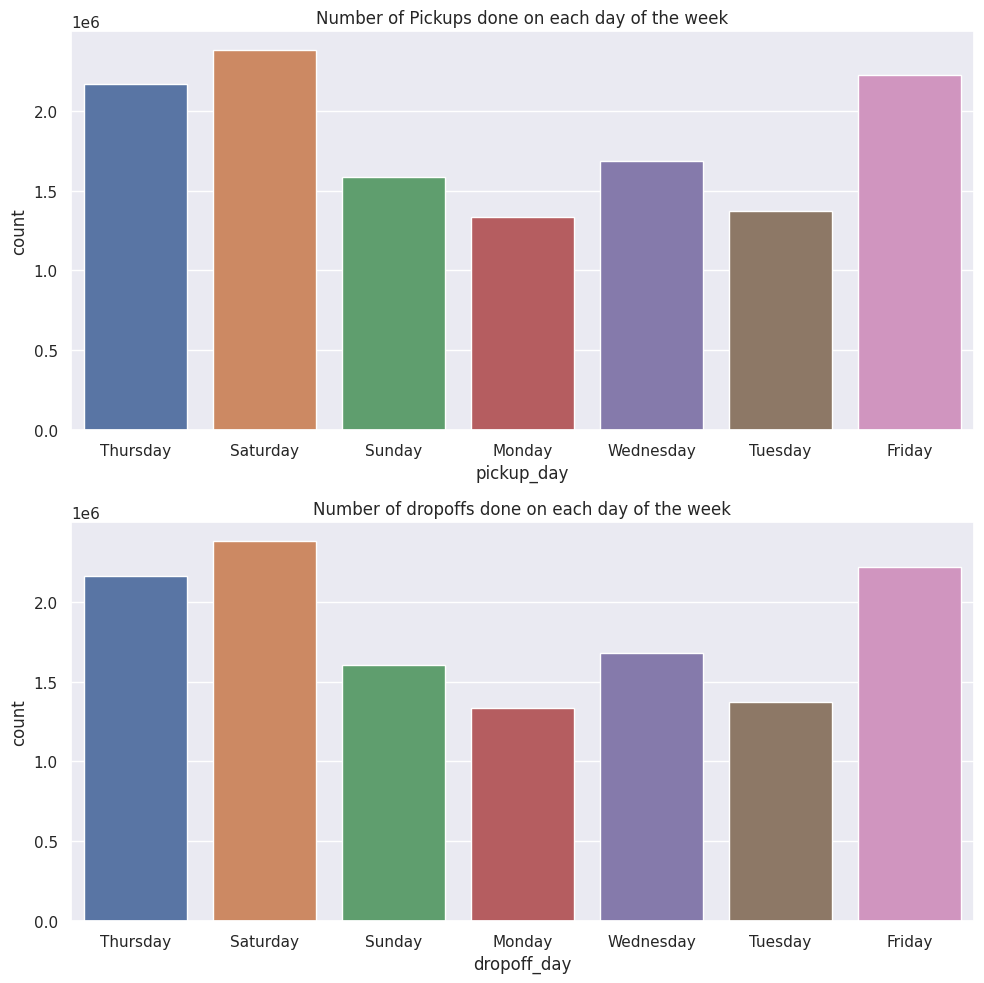

In [30]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

4. The distribution of Pickup and Drop Off hours of the day

In [26]:
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(11, 0, 0):
        return 'morning'
    elif x>=datetime.time(11, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'

df['pickup_timezone']=df['tpep_pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['tpep_dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

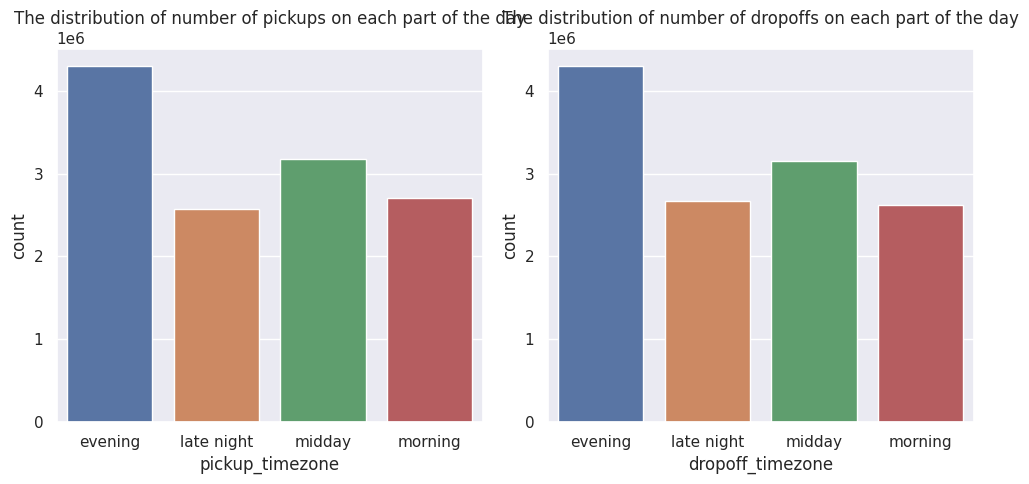

In [27]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.countplot(x='pickup_timezone',data=df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.tight_layout()

Text(0.5, 1.0, 'Distribution of dropoff hours')

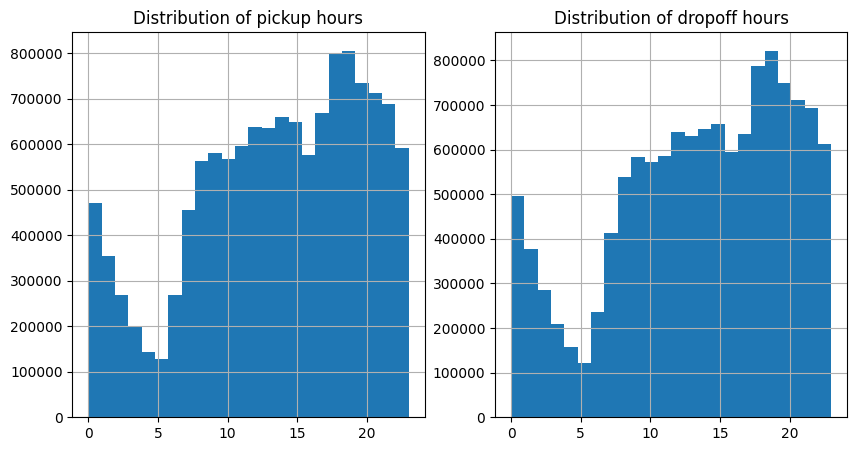

In [ ]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
df['pickup_hour']=df['tpep_pickup_datetime'].dt.hour
df.pickup_hour.hist(bins=24,ax=ax[0])
ax[0].set_title('Distribution of pickup hours')
df['dropoff_hour']=df['tpep_dropoff_datetime'].dt.hour
df.dropoff_hour.hist(bins=24,ax=ax[1])
ax[1].set_title('Distribution of dropoff hours')

5. Distribution of the stored and forward flag



In [34]:
df['store_and_fwd_flag'].value_counts()

N    12633570
Y      115033
Name: store_and_fwd_flag, dtype: int64

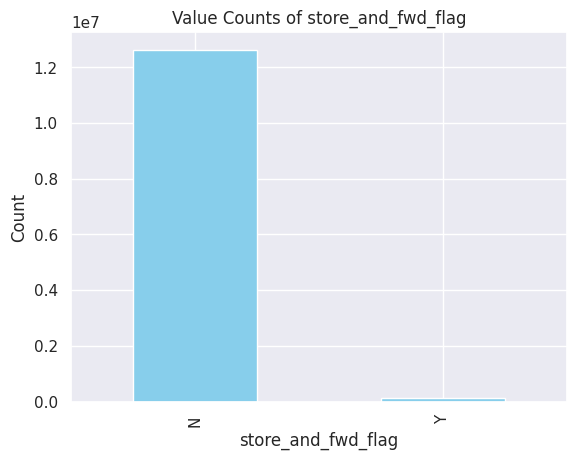

In [25]:
# Plotting the value counts

df['store_and_fwd_flag'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Value Counts of store_and_fwd_flag')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Count')
plt.show()


6. Distribution of Longitude and Latitude

<ipython-input-26-33214a320c3f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['dropoff_longitude'])


Text(0.5, 1.0, 'The distribution of Drop off Longitude')

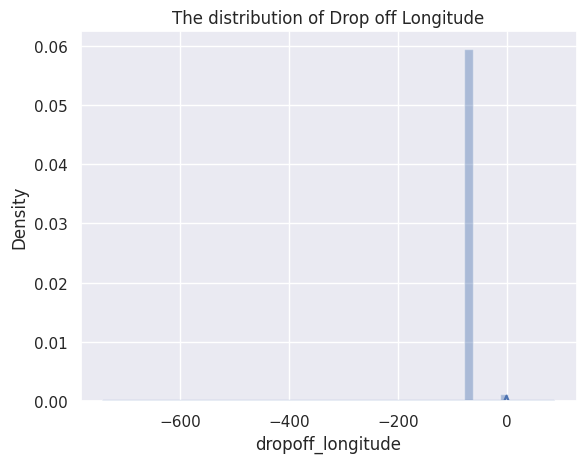

In [26]:
sns.distplot(df['dropoff_longitude'])
plt.title('The distribution of Drop off Longitude')

<ipython-input-27-6cdf7dc0ad5f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['pickup_longitude'])


Text(0.5, 1.0, 'The distribution of Pick up Longitude')

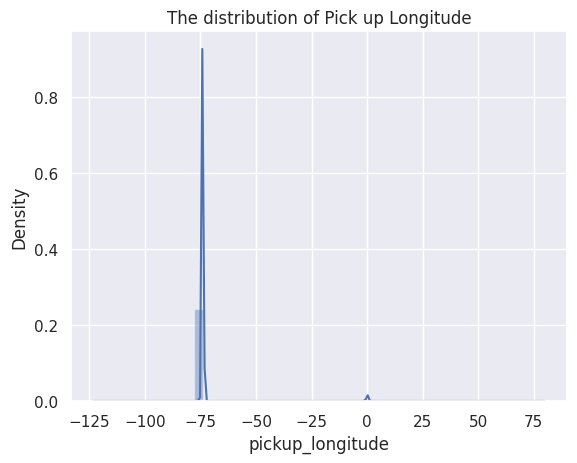

In [27]:
sns.distplot(df['pickup_longitude'])
plt.title('The distribution of Pick up Longitude')

<ipython-input-15-7d9851bce4a5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['dropoff_latitude'])


Text(0.5, 1.0, 'The distribution of drop off Latitude')

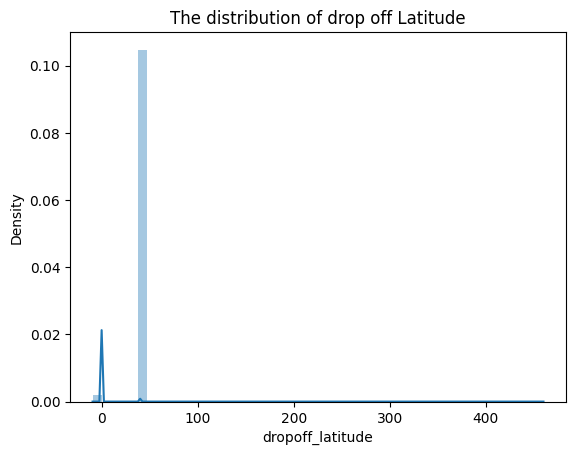

In [ ]:
sns.distplot(df['dropoff_latitude'])
plt.title('The distribution of drop off Latitude')

<ipython-input-16-0c9c08505afb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['pickup_latitude'])


Text(0.5, 1.0, 'The distribution of pick up Latitude')

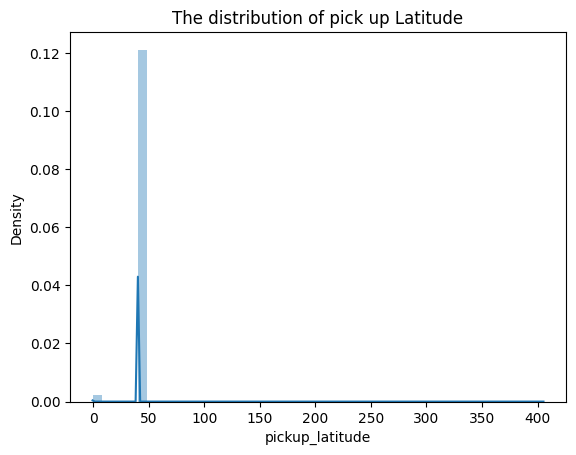

In [ ]:
sns.distplot(df['pickup_latitude'])
plt.title('The distribution of pick up Latitude')



In [41]:
# Create a new column 'trip_duration_category' based on duration
df['duration_category'] = pd.cut(df['duration'].dt.total_seconds(), bins=[0, 1800, 3600, 5400, 7200, 90000], labels=["< 5", "5-10", "10-15", "15-20", ">20"])

# Display the DataFrame with the new category column
print(df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'duration', 'duration_category']])


         tpep_pickup_datetime tpep_dropoff_datetime        duration  \
0         2015-01-15 19:05:39   2015-01-15 19:23:42 0 days 00:18:03   
1         2015-01-10 20:33:38   2015-01-10 20:53:28 0 days 00:19:50   
2         2015-01-10 20:33:38   2015-01-10 20:43:41 0 days 00:10:03   
3         2015-01-10 20:33:39   2015-01-10 20:35:31 0 days 00:01:52   
4         2015-01-10 20:33:39   2015-01-10 20:52:58 0 days 00:19:19   
...                       ...                   ...             ...   
12748981  2015-01-10 19:01:44   2015-01-10 19:05:40 0 days 00:03:56   
12748982  2015-01-10 19:01:44   2015-01-10 19:07:26 0 days 00:05:42   
12748983  2015-01-10 19:01:44   2015-01-10 19:15:01 0 days 00:13:17   
12748984  2015-01-10 19:01:44   2015-01-10 19:17:03 0 days 00:15:19   
12748985  2015-01-10 19:01:45   2015-01-10 19:07:33 0 days 00:05:48   

         duration_category  
0                      < 5  
1                      < 5  
2                      < 5  
3                      < 5  
4 

[1 2 3 4 5]


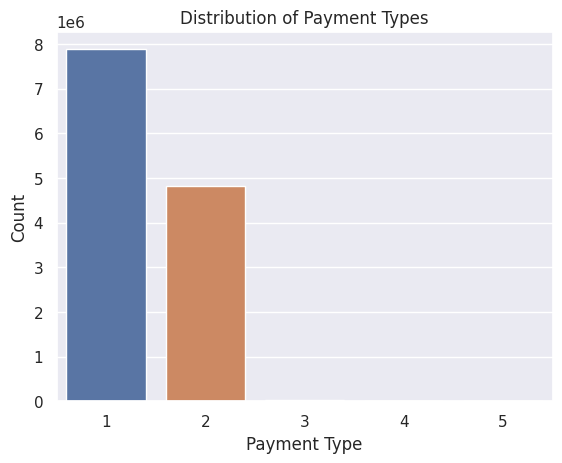

In [29]:
# Print unique values in 'payment_type'
print(df['payment_type'].unique())

# Create a count plot
sns.countplot(x='payment_type', data=df)

# Set labels and title
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.title('Distribution of Payment Types')

# Show the plot
plt.show()


In [9]:
import pandas as pd

# Assuming df is your DataFrame
index_to_remove = 10862961

# Drop the row in place
df.drop(index_to_remove, inplace=True)

# Now, df does not contain the row with index 10862961


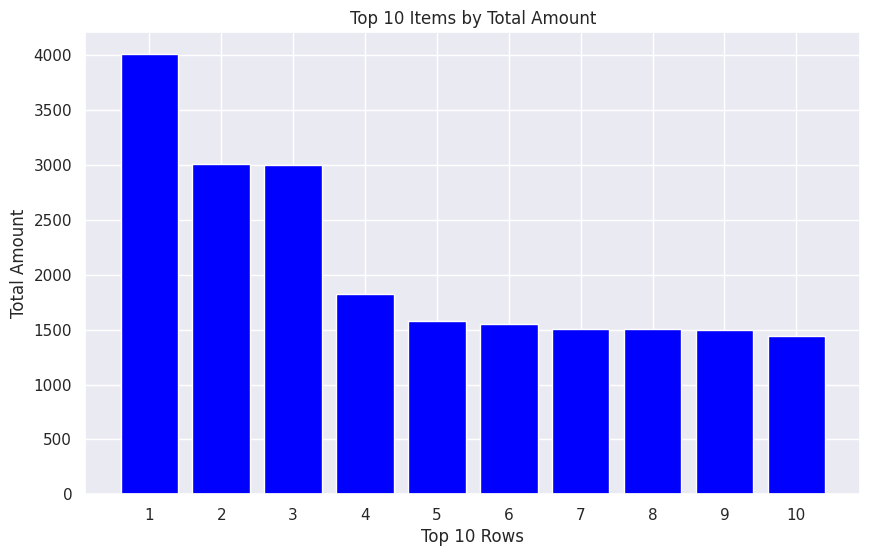

In [10]:

# Assuming df is your DataFrame and 'total_amount' is the column of interest
sorted_df = df.sort_values(by='total_amount', ascending=False)

# Select the top 10 rows
top_10 = sorted_df.head(10)


plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), top_10['total_amount'], color='blue')
plt.xlabel('Top 10 Rows')
plt.ylabel('Total Amount')
plt.title('Top 10 Items by Total Amount')
plt.xticks(range(1, 11))  # Use integers for x-axis labels
plt.show()

In [11]:
top_10

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
12477051,1,2015-01-22 21:12:26,2015-01-22 21:20:36,1,1.7,-73.961533,40.770638,1,N,-73.978508,40.749516,2,4008.00,0.50,0.5,0.0,0.00,0.3,4009.30
1851068,2,2015-01-02 20:06:34,2015-01-02 20:23:33,1,0.4,-74.014336,40.711857,1,N,-73.985191,40.760464,2,3005.50,0.05,0.5,0.0,0.00,0.3,3006.35
3590037,2,2015-01-23 11:15:00,2015-01-23 11:15:00,1,0.0,0.000000,0.000000,5,N,0.000000,0.000000,1,999.99,999.99,0.0,0.0,999.99,0.0,2999.97
3353313,2,2015-01-30 12:10:00,2015-01-30 12:10:00,1,0.0,0.000000,0.000000,5,N,0.000000,0.000000,1,821.00,0.00,0.0,0.0,999.99,0.0,1820.99
6484239,1,2015-01-09 17:42:08,2015-01-09 17:43:29,4,0.0,-73.591827,40.685993,5,N,-73.591827,40.685997,1,965.00,0.00,0.0,550.0,59.00,0.3,1574.30
12664616,1,2015-01-12 01:41:43,2015-01-12 01:42:32,4,0.0,-73.591759,40.685711,5,N,-73.591759,40.685711,1,978.00,0.00,0.0,569.0,0.00,0.3,1547.30
5189604,1,2015-01-06 18:27:38,2015-01-06 19:04:04,2,18.5,0.000000,0.000000,2,N,0.000000,0.000000,2,52.00,0.00,0.5,0.0,1450.09,0.3,1502.89
738651,1,2015-01-07 13:00:53,2015-01-07 13:02:30,4,0.0,-73.591835,40.686081,5,N,-73.591858,40.686069,1,949.99,0.00,0.0,551.0,0.00,0.3,1501.29
10141593,1,2015-01-17 05:54:37,2015-02-02 18:34:38,4,0.0,-73.811417,40.691956,5,N,-73.811417,40.691952,1,965.00,0.00,0.0,534.7,0.00,0.3,1500.00
11519477,2,2015-01-06 14:47:00,2015-01-06 14:47:00,1,0.0,0.000000,0.000000,5,N,0.000000,0.000000,1,999.99,445.87,0.0,0.0,0.00,0.0,1445.86


In [11]:
sorted_df = df.sort_values(by='tip_amount', ascending=False)

# Select the top 10 rows
top_10 = sorted_df.head(10)
top_10

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
6715949,1,2015-01-22 21:58:47,2015-01-22 22:07:14,2,1.9,-73.991280,40.750710,1,N,-73.993614,40.729565,1,8.00,0.5,0.5,888.20,0.0,0.3,897.50
5036510,1,2015-01-02 08:01:51,2015-01-02 08:04:06,1,0.0,-74.010933,40.630848,2,N,-74.010933,40.630856,1,52.00,0.0,0.5,850.00,0.0,0.0,902.80
329377,1,2015-01-09 10:28:45,2015-01-09 10:28:53,1,0.0,-74.010956,40.630894,2,N,-74.010941,40.630894,1,52.00,0.0,0.5,750.00,0.0,0.3,802.80
4482329,1,2015-01-23 12:56:38,2015-01-23 13:11:49,1,3.6,-74.012794,40.643936,3,N,-73.979752,40.685059,1,32.00,0.0,0.0,700.00,0.0,0.3,732.30
4839222,1,2015-01-20 10:49:25,2015-01-21 07:59:04,1,0.0,0.000000,0.000000,1,Y,0.000000,0.000000,1,635.50,0.0,0.0,635.80,0.0,0.3,1271.60
9674735,1,2015-01-04 03:22:26,2015-01-04 03:31:04,1,1.4,-74.002258,40.733746,1,N,-73.984161,40.725433,1,7.50,0.5,0.5,606.57,0.0,0.0,615.37
12664616,1,2015-01-12 01:41:43,2015-01-12 01:42:32,4,0.0,-73.591759,40.685711,5,N,-73.591759,40.685711,1,978.00,0.0,0.0,569.00,0.0,0.3,1547.30
738651,1,2015-01-07 13:00:53,2015-01-07 13:02:30,4,0.0,-73.591835,40.686081,5,N,-73.591858,40.686069,1,949.99,0.0,0.0,551.00,0.0,0.3,1501.29
6484239,1,2015-01-09 17:42:08,2015-01-09 17:43:29,4,0.0,-73.591827,40.685993,5,N,-73.591827,40.685997,1,965.00,0.0,0.0,550.00,59.0,0.3,1574.30
10141593,1,2015-01-17 05:54:37,2015-02-02 18:34:38,4,0.0,-73.811417,40.691956,5,N,-73.811417,40.691952,1,965.00,0.0,0.0,534.70,0.0,0.3,1500.00


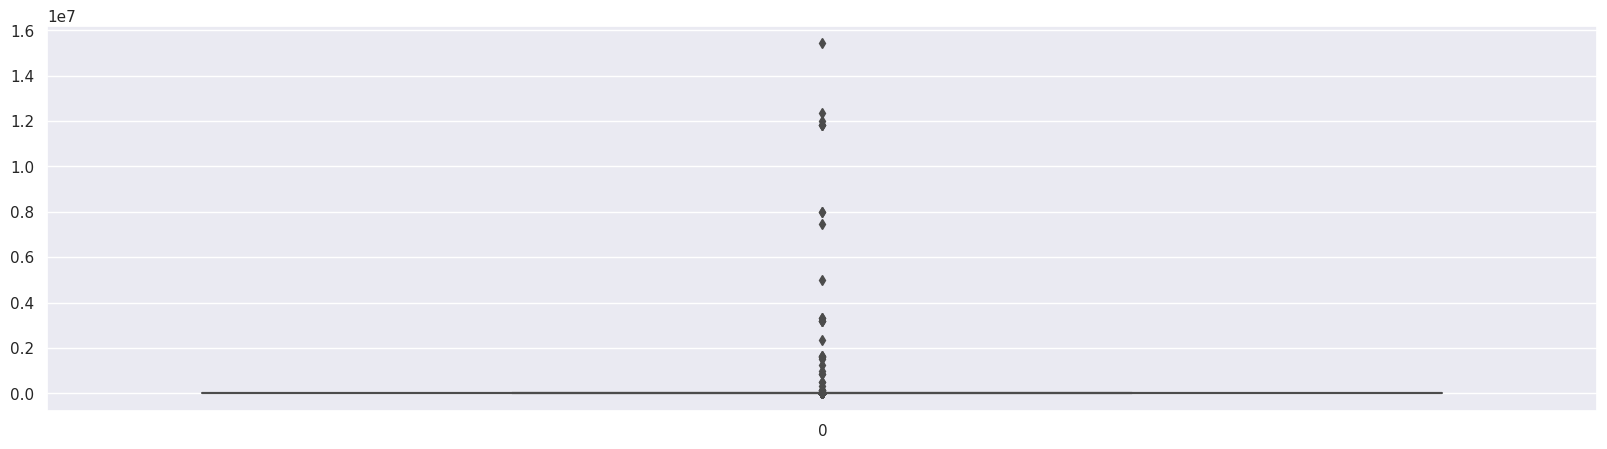

In [12]:
plt.figure(figsize = (20,5))
sns.boxplot(df.trip_distance)
plt.show()

In [13]:
print(f"There are {df.trip_distance[df.trip_distance == 0 ].count()} trip records with 0 miles distance")

There are 79365 trip records with 0 miles distance


There are 79365 trip records with 0 miles distance.

Around 6K trip record with distance equal to 0. Below are some possible explanation for such records.
Customer changed mind and cancelled the journey just after accepting it.

Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
Issue with GPS tracker while the journey is being finished.

Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
Or some other issue with the software itself which a technical guy can explain
T
here is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

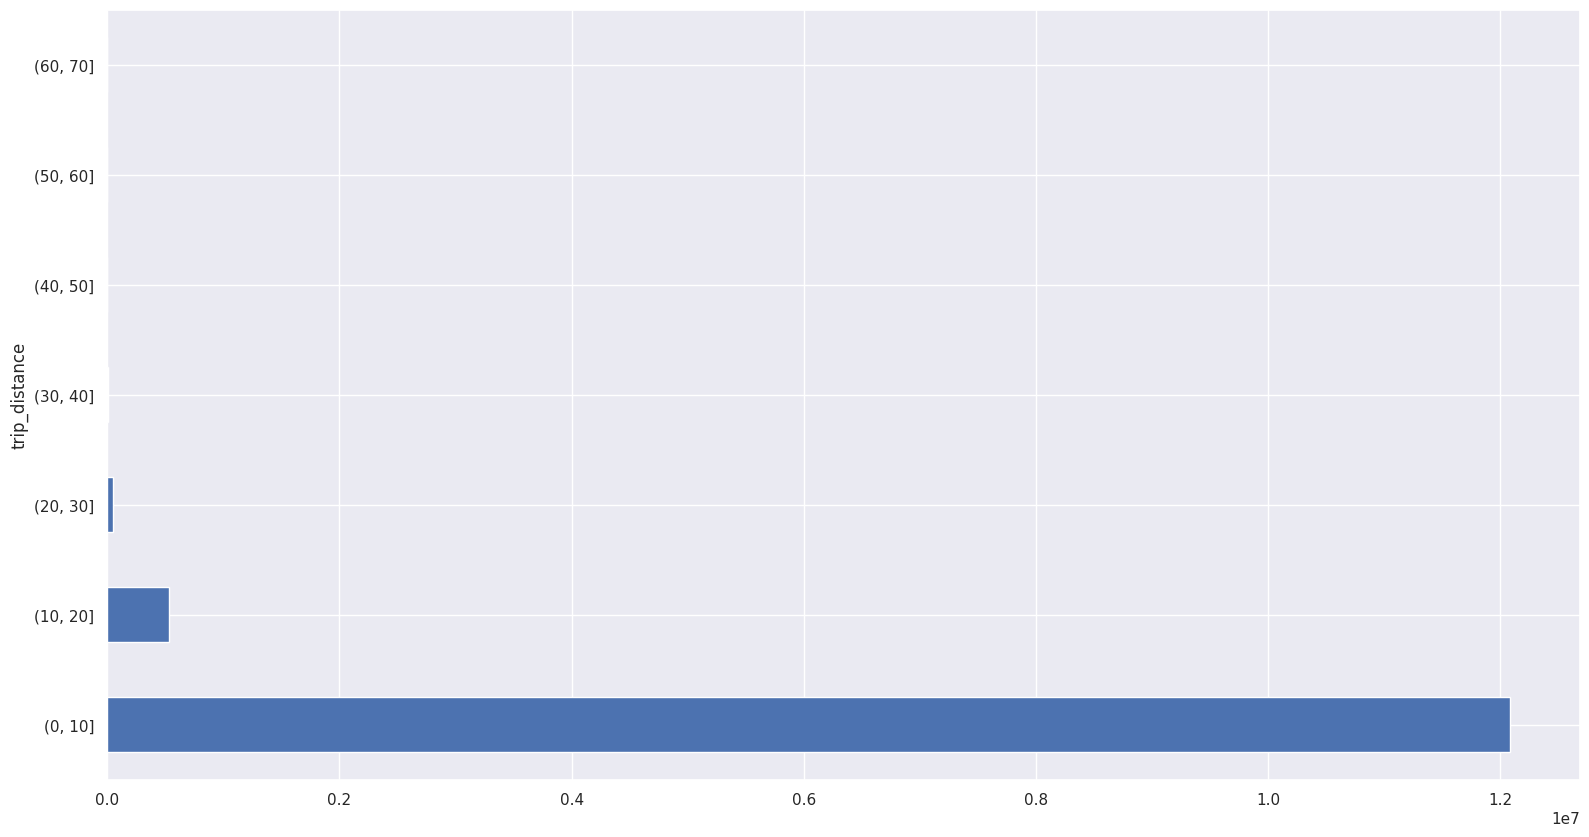

In [17]:
df.trip_distance.groupby(pd.cut(df.trip_distance, np.arange(0,80,10))).count().plot(kind='barh',figsize = (19,10))
plt.show()

In [20]:
df_short = df[df.trip_distance <= 30].shape[0]
df_long = df[df.trip_distance > 30].shape[0]

print(f"Short Trips: {df_short} records in total.")
print(f"Long Trips: {df_long} records in total.")


Short Trips: 12745595 records in total.
Long Trips: 3390 records in total.
